## Instalando e Carregando os Pacotes

In [2]:
# Instalação do pacote do Mongodb
!pip install -q pymongo

In [1]:
# Bibliotecas
import json
import pymongo 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

## Conectando no Data Lake

In [2]:
# Abre uma conexão Mongo
client = pymongo.MongoClient("mongodb://localhost:27017/")

In [3]:
# Visualizando a conexão
client

MongoClient(host=['localhost:27017'], document_class=dict, tz_aware=False, connect=True)

In [4]:
# Criando um repositório (banco de dados) chamado datalake
# Atenção: do lado esquerda do '=' é uma variávek python com o mesmo nome que o repositório no Mongodb
datalake = client["datalake"]
datalake

Database(MongoClient(host=['localhost:27017'], document_class=dict, tz_aware=False, connect=True), 'datalake')

>Analisando o dataset usado

In [ ]:
# Se existir, deleta a coleção chamada posts
datalake.posts.drop()

In [5]:
dataset = pd.read_json('dados/dataset.json')
dataset

,status,creationDate,allowComments,title,description,tags,Category,filteredPicture
0,public,2017-07-17T20:05:49Z,True,ligula nec sem duis aliquam,in felis eu sapien cursus vestibulum proin eu ...,1,lifestyle,False
1,private,2019-01-19T15:45:57Z,False,mus vivamus vestibulum sagittis sapien cum,nec nisi volutpat eleifend donec ut dolor morb...,0,lifestyle,False
2,private,2019-03-22T17:18:15Z,True,vel nulla eget eros elementum,quis orci nullam molestie nibh in lectus pelle...,6,politics,True
3,public,2019-05-12T13:20:40Z,True,orci luctus et,rhoncus dui vel sem sed sagittis nam congue ri...,5,movies,False
4,public,2018-07-09T18:55:10Z,False,sed lacus morbi sem,porta volutpat quam pede lobortis ligula sit a...,0,arts,True
...,...,...,...,...,...,...,...,...
1995,private,2017-06-16T01:56:15Z,False,turpis nec euismod scelerisque quam turpis,aliquet at feugiat non pretium quis lectus sus...,1,arts,True
1996,private,2018-11-14T21:40:53Z,True,nulla pede ullamcorper augue,parturient montes nascetur ridiculus mus etiam...,5,arts,True
1997,private,2017-01-26T19:50:54Z,False,sed lacus morbi sem mauris,cursus id turpis integer aliquet massa id lobo...,3,lifestyle,False
1998,private,2017-03-29T17:07:25Z,True,dui luctus rutrum nulla tellus in,sagittis dui vel nisl duis ac nibh fusce lacus...,9,lifestyle,False


In [9]:
# Cria a coleção chamada posts
posts = datalake["posts"]

## Carregando Dados no Data Lake

In [10]:
# Carrega o arquivo(formato bruto) json em uma variável Python
with open('dados/dataset.json') as file:
    file_data = json.load(file)

In [ ]:
file_data

>Como o volume de dados é pequeno, não precisamos fazer os procedimentos no Mongodb e depois, por código, trazer para o Python

In [ ]:
# Inserindo o conteúdo do arquivo json na coleção 'posts'
# Cada item do arquivo será um documento e usamos o bypass_document_validation para o caso de alguma linha corrompida, seja apresentada uma mensagem de erro
posts.insert_many(file_data, ordered = False, bypass_document_validation = True)

In [15]:
# Retorna 1 registro
posts.find_one()

{'_id': ObjectId('621562fd3cc1966e2c43e64f'),
 'status': 'public',
 'creationDate': '2017-07-17T20:05:49Z',
 'allowComments': True,
 'title': 'ligula nec sem duis aliquam',
 'description': 'in felis eu sapien cursus vestibulum proin eu mi nulla ac enim in tempor turpis nec euismod scelerisque quam turpis adipiscing lorem vitae mattis nibh ligula nec sem duis aliquam convallis nunc proin at turpis a pede posuere nonummy integer non velit donec diam neque vestibulum eget vulputate ut ultrices vel augue vestibulum ante ipsum primis in faucibus orci luctus et ultrices posuere cubilia curae donec pharetra magna vestibulum aliquet ultrices erat tortor sollicitudin mi sit amet lobortis sapien sapien non mi integer ac neque duis bibendum morbi non',
 'tags': 1,
 'Category': 'lifestyle',
 'filteredPicture': False}

In [16]:
# Extraindo o número de documentos (posts)
n = posts.estimated_document_count()

In [17]:
n

2000

## Pré-Processamento e Análise

> Agregação para calcular o número de posts em cada categoria.

In [18]:
# Calculando o número de posts por categoria
# Lembrar que o símbolo '$' é um operador do Mongodb
# SEMÂNTICA: associamos o 'id' à $Category, depois faremos um count usando o '$sum' para cada um dos elementos(1)
# Os parâmetros '1' (ordem crescente) e -1 (ordem descrescente)
posts_cat = posts.aggregate([{"$group": {"_id": "$Category", "count": {"$sum": 1}}},
                             {"$sort": {"_id.Category": 1, "count": -1}}])

In [19]:
print(posts_cat)

In [20]:
# Convetendo o resultado obtido em um Dataframe
pc_df = pd.DataFrame(list(posts_cat))

In [21]:
pc_df.head()

,_id,count
0,arts,311
1,fashion,300
2,lifestyle,294
3,movies,289
4,educational,274


In [22]:
# Listas os ids (categorias)
list(pc_df['_id'])

['arts', 'fashion', 'lifestyle', 'movies', 'educational', 'politics', 'sports']

<AxesSubplot:ylabel='count'>

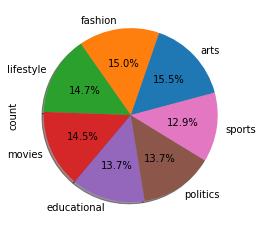

In [23]:
# Plotando com um gráfico de pizza
pc_df.plot.pie(y = 'count',
               labels = pc_df['_id'],
               autopct = '%1.1f%%',
               startangle = 15, 
               shadow = True,
               legend = False)

> Número de posts públicos e privados da categoria 'politics'.

In [24]:
# Antes de se realizar agregação, faremos um 'match', um casamento, que exerce a função de um filtro de tudo na categoria 'politics'
pol_sta = posts.aggregate([{"$match": {"Category": "politics"}},
                           {"$group": {"_id": "$status", "count": {"$sum": 1}}}])

In [25]:
# Convetendo o resultado obtido em um Dataframe
ps_df = pd.DataFrame(list(pol_sta))

In [26]:
ps_df

,_id,count
0,public,126
1,private,148


<AxesSubplot:title={'center':'Número de Posts Públicos e Privados'}, xlabel='_id'>

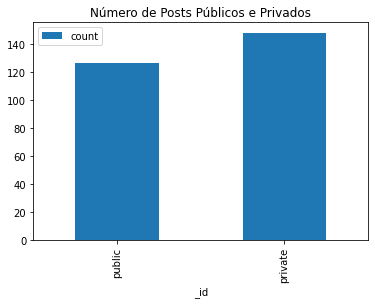

In [27]:
# Plotando em um gráfico de barras
ps_df.plot.bar(x = '_id',
               y = 'count',
               title = "Número de Posts Públicos e Privados")

> Verificando o ano que teve o maior número de posts

In [28]:
# Testando com 1 registro
# A coluna 'creationDate' nos informa a data de criação do post
posts.find_one()

{'_id': ObjectId('621562fd3cc1966e2c43e64f'),
 'status': 'public',
 'creationDate': '2017-07-17T20:05:49Z',
 'allowComments': True,
 'title': 'ligula nec sem duis aliquam',
 'description': 'in felis eu sapien cursus vestibulum proin eu mi nulla ac enim in tempor turpis nec euismod scelerisque quam turpis adipiscing lorem vitae mattis nibh ligula nec sem duis aliquam convallis nunc proin at turpis a pede posuere nonummy integer non velit donec diam neque vestibulum eget vulputate ut ultrices vel augue vestibulum ante ipsum primis in faucibus orci luctus et ultrices posuere cubilia curae donec pharetra magna vestibulum aliquet ultrices erat tortor sollicitudin mi sit amet lobortis sapien sapien non mi integer ac neque duis bibendum morbi non',
 'tags': 1,
 'Category': 'lifestyle',
 'filteredPicture': False}

Será necessário extrairmos o ano para fazermos a agregação por esse critério, para isso, faremos um pré-processamento dos dados, usando a função update.many()

In [29]:
# SEMÂNTICA: pegamos posts de datalake e chamamos a fumção update_many e dentro da função:
# {} para indicar que não há filtros; chamamos o operador $set para criar nova coluna chamada 'hour' e preenchemos com '0'
datalake.posts.update_many({}, {'$set': {'hour': 0}})
# O mesmo processo para 'year'
datalake.posts.update_many({}, {'$set': {'$year': 0}})

In [30]:
# Retorna 1 item
posts.find_one()

{'_id': ObjectId('621562fd3cc1966e2c43e64f'),
 'status': 'public',
 'creationDate': '2017-07-17T20:05:49Z',
 'allowComments': True,
 'title': 'ligula nec sem duis aliquam',
 'description': 'in felis eu sapien cursus vestibulum proin eu mi nulla ac enim in tempor turpis nec euismod scelerisque quam turpis adipiscing lorem vitae mattis nibh ligula nec sem duis aliquam convallis nunc proin at turpis a pede posuere nonummy integer non velit donec diam neque vestibulum eget vulputate ut ultrices vel augue vestibulum ante ipsum primis in faucibus orci luctus et ultrices posuere cubilia curae donec pharetra magna vestibulum aliquet ultrices erat tortor sollicitudin mi sit amet lobortis sapien sapien non mi integer ac neque duis bibendum morbi non',
 'tags': 1,
 'Category': 'lifestyle',
 'filteredPicture': False,
 'hour': 0,
 'year': 0}

In [31]:
# Fazendo a extração das datas
for data in posts.find({}): # Para cada dado dentro da coleção de dados (posts)
    posts.update_one({"_id": data['_id']}, # Verificamos se temos realmente o id correto; atualizamos (update_one)
                     {'$set': {'hour' : data['creationDate'].split('T')[1].split(':')[0],  # setamos a coluna de hora, com o valor extraido de 'creationDate'
                               'year' : data['creationDate'].split('T')[0].split('-')[0] }}
    # Lembrando que find_one() traz 1 registro específico, já find() traz todos

In [32]:
# Retorna 1 item
posts.find_one()

{'_id': ObjectId('621562fd3cc1966e2c43e64f'),
 'status': 'public',
 'creationDate': '2017-07-17T20:05:49Z',
 'allowComments': True,
 'title': 'ligula nec sem duis aliquam',
 'description': 'in felis eu sapien cursus vestibulum proin eu mi nulla ac enim in tempor turpis nec euismod scelerisque quam turpis adipiscing lorem vitae mattis nibh ligula nec sem duis aliquam convallis nunc proin at turpis a pede posuere nonummy integer non velit donec diam neque vestibulum eget vulputate ut ultrices vel augue vestibulum ante ipsum primis in faucibus orci luctus et ultrices posuere cubilia curae donec pharetra magna vestibulum aliquet ultrices erat tortor sollicitudin mi sit amet lobortis sapien sapien non mi integer ac neque duis bibendum morbi non',
 'tags': 1,
 'Category': 'lifestyle',
 'filteredPicture': False,
 'hour': '20',
 'year': '2017'}

>Agora já podemos efetuar a agregação

In [33]:
# Agregação
posts_yr = posts.aggregate([{"$group": {"_id": "$year", "count": {"$sum": 1}}},
                            {"$sort": {"_id.year": 1, "count": 1}}])

In [34]:
# Convetendo o resultado obtido em um Dataframe
py_df = pd.DataFrame(list(posts_yr))
py_df

,_id,count
0,2015,76
1,2016,299
2,2019,303
3,2017,309
4,2021,330
5,2020,334
6,2018,349


<AxesSubplot:title={'center':'Número de Posts Por Ano'}, xlabel='_id'>

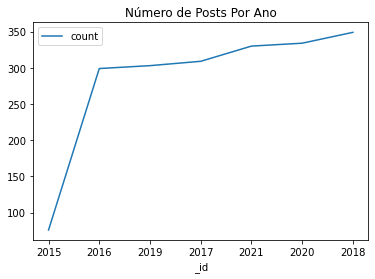

In [35]:
# Plot com gráfico de linhas
py_df.plot.line(x = '_id',
                y = 'count',
                title = "Número de Posts Por Ano")

> Exibindo o horário com maior número de posts

In [36]:
# Agregação e ordenação
posts_hr = posts.aggregate([{"$group": {"_id": "$hour", "count": {"$sum": 1}}},
                            {"$sort": {"_id.hour": 1, "count": -1}}])

In [37]:
for i in range(3):
    print(posts_hr.next())

{'_id': '00', 'count': 103}
{'_id': '08', 'count': 101}
{'_id': '02', 'count': 99}


> Número de posts em hora cheia (terminada por 00) por categoria.

In [38]:
cat_00 = posts.aggregate([{"$match": {"hour": "00"}},
                          {"$group": {"_id": "$Category", "count": {"$sum": 1}}},
                          {"$sort": {"_id.Category": 1, "count": -1}}])

In [39]:
c0_df = pd.DataFrame(list(cat_00))

<AxesSubplot:title={'center':'Número de Posts em Hora Cheia'}, xlabel='_id'>

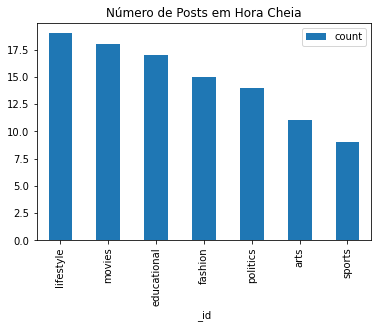

In [40]:
# Plotando com gráfico de barras
c0_df.plot.bar(
    x = '_id', 
    y = 'count', 
    title = "Número de Posts em Hora Cheia"
)

> Exibindo o número de posts que permitem comentários

In [41]:
# Contagem
com = posts.count_documents({'allowComments':True})

In [42]:
print("Número de Posts Que Permitem Comentários:", com)

Número de Posts Que Permitem Comentários: 964


In [43]:
print("Número de Posts Que Não Permitem Comentários:", n-com) # n-com é a negação da variável

Número de Posts Que Não Permitem Comentários: 1036


Text(0, 0.5, 'Número de Posts')

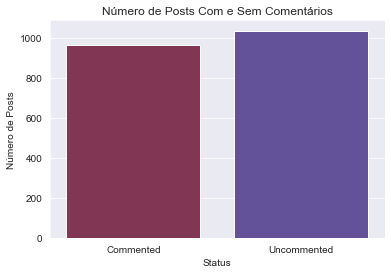

In [44]:
# Plot em barras
sns.set_style('darkgrid')
x = ['Commented', 'Uncommented']
y = [com, n-com]
sns.barplot(x, y, palette = 'twilight_r')
plt.title("Número de Posts Com e Sem Comentários")
plt.xlabel("Status")
plt.ylabel("Número de Posts")

> 1. Comprimento (número de palavras) do título dos posts, filtrando por categoria<br>
> 2. Como não temos uma coluna que exerce essa função, criaremos uma

In [45]:
# Retorna 1 item
posts.find_one()

{'_id': ObjectId('621562fd3cc1966e2c43e64f'),
 'status': 'public',
 'creationDate': '2017-07-17T20:05:49Z',
 'allowComments': True,
 'title': 'ligula nec sem duis aliquam',
 'description': 'in felis eu sapien cursus vestibulum proin eu mi nulla ac enim in tempor turpis nec euismod scelerisque quam turpis adipiscing lorem vitae mattis nibh ligula nec sem duis aliquam convallis nunc proin at turpis a pede posuere nonummy integer non velit donec diam neque vestibulum eget vulputate ut ultrices vel augue vestibulum ante ipsum primis in faucibus orci luctus et ultrices posuere cubilia curae donec pharetra magna vestibulum aliquet ultrices erat tortor sollicitudin mi sit amet lobortis sapien sapien non mi integer ac neque duis bibendum morbi non',
 'tags': 1,
 'Category': 'lifestyle',
 'filteredPicture': False,
 'hour': '20',
 'year': '2017'}

In [46]:
# Cria a nova coluna
datalake.posts.update_many({}, {'$set': {"length_of_heading": 0}}) # inicializando com 0

In [47]:
# Preenchendo a coluna
for data in posts.find({}):
    posts.update_one({"_id": data['_id']},
                     {'$set': {'length_of_heading' : len(data['title'].split(' '))}}) # pega o comprimento da string e corta pelo 'espaço'

In [49]:
# Agrupamento e ordenação
len_titles = posts.aggregate([{"$group": {"_id": "$length_of_heading", "count": {"$sum": 1}}},
                              {"$sort": {"_id.length_of_heading": 1, "count": -1}}])
len_titles 

>Note que len_titles está em um formato de cursor do pymongo, por isso, faremos a conversão em DataFrame para podermos trabalhar com um formato adequado

In [50]:
# Convertendo em DataFrame
title_df = pd.DataFrame(list(len_titles))
title_df.head(10)

,_id,count
0,3,355
1,4,345
2,1,343
3,5,337
4,6,336
5,2,284


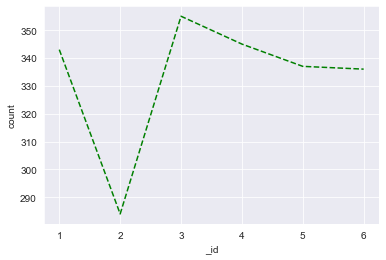

In [51]:
# Plot com gráfico de linhas
ax = sns.lineplot(x = '_id', y = 'count', data = title_df, color = 'green')
ax.lines[0].set_linestyle("--")
plt.show()

> Número de tags por categoria de posts

Etapa mais tranquila e que se resume a agregações e ordenações

In [52]:
# Agregação
tags = posts.aggregate([{"$group": {"_id": "$tags", "count": {"$sum": 1}}},
                        {"$sort": {"_id.tags": 1, "count": -1}}])

In [53]:
cat_tags = posts.find({'tags': {'$gt':0}}, {'Category':1})
cat_tags

Categorias com posts com maior número de tags e com número de tags maior do que zero

In [54]:
cat_tags = posts.aggregate([{"$match": {"tags": {"$gt":0}}},
                            {"$group": {"_id": "$Category", "count": {"$sum": 1}}},
                            {"$sort": {"_id.tags": 1, "count": -1}}])

In [55]:
ct_df = pd.DataFrame(list(cat_tags))
ct_df

,_id,count
0,fashion,276
1,arts,276
2,movies,264
3,lifestyle,262
4,politics,258
5,educational,255
6,sports,235


<AxesSubplot:xlabel='_id', ylabel='count'>

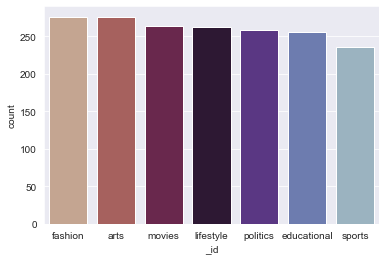

In [56]:
# Plotando
sns.barplot(x = '_id', y = 'count', data = ct_df, palette = 'twilight_r')

> Categoria usa mais filtros de fotos/imagens

In [57]:
# Filtro, agregação e ordenação
cat_fs = posts.aggregate([{"$match": {"filteredPicture": True}},
                          {"$group":{"_id": "$Category", "count": {"$sum": 1}}},
                          {"$sort": {"_id.tags": 1, "count": -1}}])

In [58]:
# Fazendo um loop e chamando sempre o próximo resultado
for i in range(7):
    print(cat_fs.next())

{'_id': 'fashion', 'count': 159}
{'_id': 'movies', 'count': 154}
{'_id': 'arts', 'count': 146}
{'_id': 'lifestyle', 'count': 136}
{'_id': 'educational', 'count': 135}
{'_id': 'politics', 'count': 131}
{'_id': 'sports', 'count': 117}


> Categorias com descrições dos posts mais longos (com maior número de palavras) e acima de 60 caracteres

In [59]:
# Criando a variável com a informação
datalake.posts.update_many({}, {'$set': {"length_of_des": 0}});

In [60]:
# Preenchendo a variável
for data in posts.find({}):
    posts.update_one({"_id": data['_id']}, {'$set': {'length_of_des': len(data['description'].split(' '))}})

In [61]:
# Filtro, agregação e ordenação
cat_des = posts.aggregate([{"$match": {"length_of_des": {"$gte":60}}},
                           {"$group":{"_id": "$Category", "count": {"$sum": 1}}},
                           {"$sort": {"_id.tags": 1, "count": -1}}])

In [62]:
# Imprimindo os resultados
for i in range(7):
    print(cat_des.next())

{'_id': 'arts', 'count': 178}
{'_id': 'fashion', 'count': 161}
{'_id': 'movies', 'count': 159}
{'_id': 'educational', 'count': 156}
{'_id': 'lifestyle', 'count': 156}
{'_id': 'politics', 'count': 146}
{'_id': 'sports', 'count': 130}


>Variação do número de posts (descrição) por hora e dia (se eles aumentam ou diminuem)

In [63]:
# Agregação e ordenação por hora e categoria
posts_hr = posts.aggregate([{"$group": {"_id": ["$hour", "$Category"], "count": {"$sum": 1}}},
                            {"$sort": {"_id.hour": 1, "count": -1}}])

In [64]:
postshr_df = pd.DataFrame(posts_hr)
postshr_df

,_id,count
0,"[11, arts]",23
1,"[08, politics]",21
2,"[16, lifestyle]",20
3,"[11, educational]",20
4,"[05, arts]",19
...,...,...
163,"[06, sports]",5
164,"[22, politics]",5
165,"[13, sports]",5
166,"[11, lifestyle]",4


>Apesar de ter facilitado para visualizarmos o horário e a categoria dos posts, não daria para plotar tais resultados para análise, por isso, faremos um split em 2 partes da coluna _id

In [65]:
# Split
split_df = pd.DataFrame(postshr_df ['_id'].to_list(), columns = ['hour', 'category'])
split_df

,hour,category
0,11,arts
1,08,politics
2,16,lifestyle
3,11,educational
4,05,arts
...,...,...
163,06,sports
164,22,politics
165,13,sports
166,11,lifestyle


In [66]:
# Concatenação
df = pd.concat([split_df, postshr_df['count']], axis = 1)
df

,hour,category,count
0,11,arts,23
1,08,politics,21
2,16,lifestyle,20
3,11,educational,20
4,05,arts,19
...,...,...,...
163,06,sports,5
164,22,politics,5
165,13,sports,5
166,11,lifestyle,4


In [67]:
df.head(10)

,hour,category,count
0,11,arts,23
1,08,politics,21
2,16,lifestyle,20
3,11,educational,20
4,05,arts,19
5,00,lifestyle,19
6,10,fashion,19
7,02,lifestyle,19
8,14,fashion,18
9,22,lifestyle,18


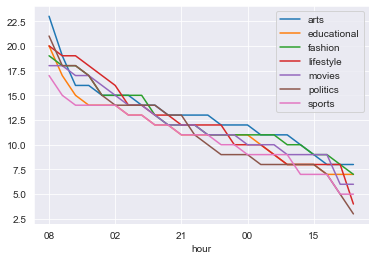

In [68]:
# Plotando a análise
fig, ax = plt.subplots()
for key, grp in df.groupby(['category']):
    ax = grp.plot(ax = ax, kind = 'line', x = 'hour', y = 'count', label = key)

plt.legend(loc = 'best')
plt.show()

# Fim

**Agradecimento:** DSA <br><br>
Mais sobre o autor: https://linktr.ee/universo_jonatas